# **Egg Inc Artifact Analysis**

## **Introduction**

*Egg, Inc.* is an idle game centered on building the largest and most efficient egg farm possible. Farm size is measured in bocks, with larger farms producing higher earnings. The game features several core components: hen houses, vehicles, research, and artifacts.

- **Hen houses** increase the capacity for chickens, enabling higher egg production and earnings.  
- **Vehicles** expand the farm's ability to transport eggs, maximizing sales potential.  
- **Research** provides upgrades to various aspects of the farm, such as increasing chicken production rates, enhancing egg value, and boosting the efficiency of operations.  

Lastly, **artifacts** are special items that enhance gameplay by providing unique boosts, such as increased egg value or accelerated production rates. Artifacts vary by type, rarity, and tier, with rarities classified as common, rare, epic, or legendary. Each artifact also has a tier, ranging from Tier 1 (T1) to Tier 4 (T4), which influences its stats and the number of stone slots it has. Stones, which can be slotted into artifacts, offer additional benefits like improved egg-laying rates or shipping efficiency. Higher-tier and higher-rarity artifacts typically have more stone slots, making them significantly more powerful when optimized.

Artifacts can be obtained in two primary ways:  
1. **Spaceships:** Launching missions from the home farm offers a chance to acquire artifacts, including high-rarity items.  
2. **Crafting:** Certain rare artifacts and stones can only be crafted in the Hall of Artifacts, allowing players to customize and upgrade their inventory.  

Artifacts are often referenced using shorthand notation, combining their tier and rarity (e.g., "T3R cube" for a rare Tier 3 Mystical Puzzle Cube or "T4L chalice" for a legendary Tier 4 Eggceptional Chalice).

### **Purpose of the Report**
This report aims to analyze the effectiveness and strategic implications of artifact acquisition in *Egg, Inc.*, focusing on the following key questions:
- How effective is spaceship targeting in obtaining specific artifacts?  
- Under what conditions is targeting most beneficial?  
- What impact does targeting have on obtaining legendary artifacts?  
- When is crafting a better alternative to direct drops from spaceships?  

Through this analysis, the report will provide insights into optimizing artifact acquisition strategies to enhance farm performance.

## **Data**

[Link to Data Documentation](https://github.com/menno-egginc/eggincdatacollection-docs/blob/main/DataEndpoints.md)

The data used in this analysis is found in the link above. Menno on Discord created a tool that allows players to submit their spaceship data, and Carpet incorporated this tool into the rockets tracker. 

### **Data Description**
Each row contains the following information:
- **Ship type**: The type of spaceship used.
- **Ship duration**: The duration of the spaceship's mission.
- **Target of the ship**: The artifact or resource the ship was sent to retrieve.
- **Collected artifact details**:
  - The artifact collected from the mission.
  - Rarity and tier of the artifact.
- **Total drops**: The total number of artifacts of the specified configuration brought back by the given ship type.

### **Example Row**
In the first row of the dataframe, we see data for a Henerprise Extended ship targeting Gold Meteorites. Across all observed data points, this ship type brought back 136,251 Tier 1 Common Gold Meteorites. 

For non-numeric fields, there is an ID mapping to both an API name and an in-game name, which helps link the data to its corresponding identifiers.

In [4]:
import pandas as pd
import requests
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import random
from statsmodels.stats.proportion import proportions_ztest
import pandas as pd
import matplotlib.ticker as mtick
from IPython.display import display, Markdown
import os
from numba import njit, prange

In [5]:
base_url = "https://eggincdatacollection.azurewebsites.net/api/GetFilteredDataCsv"

filtered_url = f"{base_url}?shipType=atreggies&shipDurationType=epic&includeArtifactParameters=true"

response = requests.get(base_url)

if response.status_code == 200:
    csv_data = StringIO(response.text)
    df = pd.read_csv(csv_data)
else:
    print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")

df.head()

,Ship type ID,Ship type,Ship duration type ID,Ship duration type,Ship level,Target artifact ID,Target artifact,Artifact type ID,Artifact type,Artifact rarity ID,Artifact rarity,Artifact tier,Total drops
0,9,HENERPRISE,2,EPIC,7,17,GOLD_METEORITE,17,GOLD_METEORITE,0,COMMON,1,136292
1,9,HENERPRISE,2,EPIC,7,17,GOLD_METEORITE,33,LUNAR_STONE,0,COMMON,1,1748
2,9,HENERPRISE,2,EPIC,7,17,GOLD_METEORITE,23,PUZZLE_CUBE,0,COMMON,3,1173
3,9,HENERPRISE,2,EPIC,7,17,GOLD_METEORITE,17,GOLD_METEORITE,0,COMMON,0,34430
4,9,HENERPRISE,2,EPIC,7,17,GOLD_METEORITE,43,SOLAR_TITANIUM,0,COMMON,1,13203


Most of the player base launches **Henliners**, so that's what we will focus on in this report. Henliners are considered the best ships in the game, and the common consensus among players is to rush to these ships and level them up as quickly as possible. 

At the time of writing (December 30, 2024), Henliners have been in the game for about 8 months. Based on the best available configuration, no player should have legitimately reached higher than 7 stars, as it takes approximately 13-14 months to reach the maximum level. 

However, the data includes 8-star Henliners, likely resulting from glitchers. Despite this, we will keep them in the dataset since the underlying drop data remains valid, even if the ships themselves were obtained through illegitimate means.

In [7]:
total_ships_drops = df['Total drops'].sum()
atreggies_drops = df[(df['Ship type'] == 'ATREGGIES') & 
    (df['Ship duration type'] == 'EPIC')]['Total drops'].sum()

print(f"Proportion of Artifacts that come from Extended Atreggies Henliners:': {round(atreggies_drops * 100/total_ships_drops,2)}%")

Proportion of Artifacts that come from Extended Atreggies Henliners:': 67.83%


With this in mind, let's filter the data from the source only focusing on Extended Atreggies Henliners. 

In [9]:
response = requests.get(filtered_url)

if response.status_code == 200:
    # Convert the CSV data into a Pandas DataFrame
    csv_data = StringIO(response.text)
    ships = pd.read_csv(csv_data)
    print("Data successfully loaded into DataFrame!")
else:
    print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")

ships.head()

Data successfully loaded into DataFrame!


,Ship type ID,Ship type,Ship duration type ID,Ship duration type,Ship level,Target artifact ID,Target artifact,Artifact type ID,Artifact type,Artifact rarity ID,Artifact rarity,Artifact tier,Total drops
0,10,ATREGGIES,2,EPIC,0,24,QUANTUM_METRONOME,8,ORNATE_GUSSET,0,COMMON,2,4356
1,10,ATREGGIES,2,EPIC,0,24,QUANTUM_METRONOME,44,DILITHIUM_STONE_FRAGMENT,0,COMMON,0,1880
2,10,ATREGGIES,2,EPIC,0,24,QUANTUM_METRONOME,18,TAU_CETI_GEODE,0,COMMON,1,14696
3,10,ATREGGIES,2,EPIC,0,24,QUANTUM_METRONOME,26,TACHYON_DEFLECTOR,0,COMMON,0,7243
4,10,ATREGGIES,2,EPIC,0,24,QUANTUM_METRONOME,38,LIFE_STONE,0,COMMON,0,1369


Something else we would like to know is the distribution of artifacts collected by star level. 

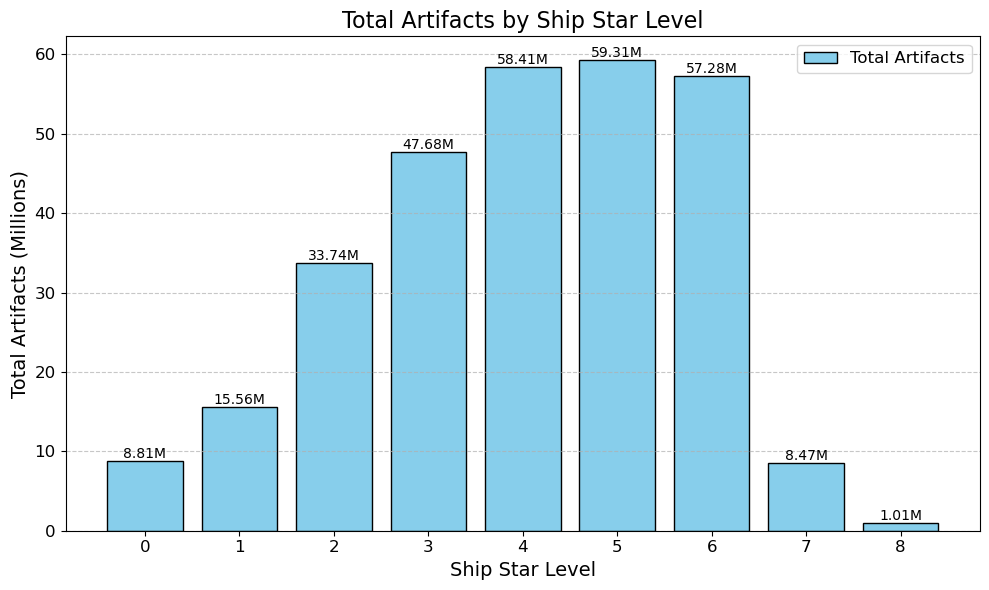

In [11]:
artifacts_per_star = []

for star in range(0, 9):
    total_artifacts = ships[(ships['Ship level'] == star)]['Total drops'].sum()
    artifacts_per_star.append(total_artifacts)

artifacts_per_star_millions = [x / 1_000_000 for x in artifacts_per_star]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(0, 9), artifacts_per_star_millions, color='skyblue', edgecolor='black', label='Total Artifacts')
plt.grid(visible=True, axis='y', linestyle='--', alpha=0.7)
plt.title("Total Artifacts by Ship Star Level", fontsize=16)
plt.xlabel("Ship Star Level", fontsize=14)
plt.ylabel("Total Artifacts (Millions)", fontsize=14)
plt.xticks(range(0, 9), fontsize=12)
plt.yticks(fontsize=12)

for bar, total in zip(bars, artifacts_per_star_millions):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{total:.2f}M", ha='center', va='bottom', fontsize=10)

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

From the graph above, we can see many players are on their way to 8 stars with most players currently around 4 to 6. 

In [13]:
ship_dict = {
    0: "Chicken One",
    1: "Chicken Nine",
    2: "Chicken Heavy",
    3: "BCR",
    4: "Quintillion Chicken",
    5: "Cornish-Hen Corvette",
    6: "Galeggtica",
    7: "Defihent",
    8: "Voyegger",
    9: "Henerprise",
    10: "Atreggies Henliner"
}

artis_per_spaceshiptype = []
for ship in ship_dict:
    total = df[df['Ship type ID'] == ship]['Total drops'].sum()
    artis_per_spaceshiptype.append((ship_dict[ship], total, round(total*100/total_ships_drops, 2)))

artis_per_spaceshiptype.append(('Sum', total_ships_drops, 100))
                               
artis_per_spaceshiptype_df = pd.DataFrame(artis_per_spaceshiptype, columns=['Artifact Name', 'Total', 'Percentage (%)']).set_index('Artifact Name')
artis_per_spaceshiptype_df['Total'] = artis_per_spaceshiptype_df['Total'].apply(lambda x: f"{x:,}")
artis_per_spaceshiptype_df

,Total,Percentage (%)
Artifact Name,,
Chicken One,"92,724",0.02
Chicken Nine,"270,544",0.06
Chicken Heavy,"3,155,964",0.74
BCR,"3,116,998",0.73
Quintillion Chicken,"1,465,027",0.34
Cornish-Hen Corvette,"3,117,102",0.73
Galeggtica,"5,883,489",1.37
Defihent,"4,455,587",1.04
Voyegger,"7,084,801",1.66


## **Effect of Targeting**

The main point of concern is the effect of targeting. For every spaceship launch, players have the option to target specific artifacts they wish to obtain. Not all artifacts drop evenly, and some are more desirable or useful than others. A particular focus of this analysis is the drop rates of legendary artifacts, which are among the most powerful artifact rarities in the game and highly sought after by players.

### **Initial Analysis**
This analysis focuses on Tier 4 artifacts that have a legendary variant available through spaceship drops. The data includes:
- The number of drops for each artifact.
- The rarity distribution of these artifacts.

The data is compiled into a dataframe, where **U** indicates untargeted ships and **T** indicates targeted ships for the relevant artifacts.

### **Key Considerations**
- **8-star ships:** While these cannot be obtained legitimately at the time of writing, they are included in the analysis. This primarily affects the Tier 4 **Light of Eggendil**, which drops very rarely from 8-star Henliners.
- **Excluded Artifacts:** Certain artifacts, such as the Tier 4 **Book of Basan** and **Tachyon Deflector**, are undroppable regardless of ship star level. These have been excluded from the analysis.

This approach aims to evaluate how targeting impacts the rarity distribution and total drops for these valuable artifacts.

In [15]:
LegArtifactIDs = [0, 3, 4, 5, 6, 7, 8, 9, 11, 12, 21, 22, 23, 24, 25, 27, 28, 29, 30]
AllTargetIDs = [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 10000]
Artifact_dict = {
    0: "Lunar totem", 1: "Tachyon stone", 2: "Tachyon stone fragment", 3: "Neodymium medallion",
    4: "Beak of Midas", 5: "Light of Eggendil", 6: "Demeters necklace", 7: "Vial of Martian dust",
    8: "Gusset", 9: "The Chalice", 10: "Book of Basan", 11: "Phoenix feather", 12: "Tungsten Ankh",
    13: "n/a", 14: "n/a", 15: "n/a", 16: "n/a", 17: "Gold meteorite", 18: "Tau ceti geode",
    19: "n/a", 20: "n/a", 21: "Aurelian brooch", 22: "Carved rainstick", 23: "Puzzle cube",
    24: "Quantum metronome", 25: "Ship in a bottle", 26: "Tachyon Deflector", 27: "Interstellar compass",
    28: "Dilithium monocle", 29: "Titanium actuator", 30: "Mercurys lens", 31: "Dilithium stone",
    32: "Shell stone", 33: "Lunar stone", 34: "Soul stone", 35: "n/a", 36: "Quantum stone",
    37: "Terra stone", 38: "Life stone", 39: "Prophecy stone", 40: "Clarity stone", 41: "n/a",
    42: "n/a", 43: "Solar titanium", 44: "Dilithium stone fragment", 45: "Shell stone fragment",
    46: "Lunar stone fragment", 47: "Soul stone fragment", 48: "Prophecy stone fragment",
    49: "Quantum stone fragment", 50: "Terra stone fragment", 51: "Life stone fragment",
    52: "Clarity stone fragment", 10000: "Unknown / No target"
}
rarity_levels = ['COMMON', 'RARE', 'EPIC', 'LEGENDARY']
data = []
artifacts = []

for id in LegArtifactIDs:
    artifact_name = Artifact_dict[id]
    artifactID = id
    targeted_data = ships[(ships['Target artifact ID'] == id)]
    untargeted_data = ships[(ships['Target artifact ID'] == 10000)]
    targeted_tier4_data = targeted_data[targeted_data['Artifact tier'] == 3]
    untargeted_tier4_data = untargeted_data[untargeted_data['Artifact tier'] == 3]
    target_tier4_total = targeted_tier4_data[targeted_tier4_data['Artifact type ID'] == id]['Total drops'].sum()
    untarget_tier4_total = untargeted_tier4_data[untargeted_tier4_data['Artifact type ID'] == id]['Total drops'].sum()
    target_all_tiers_total = targeted_data['Total drops'].sum()
    untarget_all_tiers_total = untargeted_data['Total drops'].sum()
    targeted_rarity_counts = {
        rarity: targeted_data[
            (targeted_data['Artifact rarity'] == rarity) &
            (targeted_data['Artifact type ID'] == id) &
            (targeted_data['Artifact tier'] == 3)
        ]['Total drops'].sum() for rarity in rarity_levels
    }
    untargeted_rarity_counts = {
        rarity: untargeted_data[
            (untargeted_data['Artifact rarity'] == rarity) &
            (untargeted_data['Artifact type ID'] == id) &
            (untargeted_data['Artifact tier'] == 3)
        ]['Total drops'].sum() for rarity in rarity_levels
    }
    targeted_drop_rate_percent = round(target_tier4_total * 100 / target_all_tiers_total, 3)
    untargeted_drop_rate_percent = round(untarget_tier4_total * 100 / untarget_all_tiers_total, 3)
    artifacts.append(artifact_name)
    data.append({
        'T Legendary Drop Rate': round(targeted_rarity_counts['LEGENDARY'] * 100 / target_tier4_total, 3),
        'U Legendary Drop Rate': round(untargeted_rarity_counts['LEGENDARY'] * 100 / untarget_tier4_total, 3),
        'T Drop Rate Percent': targeted_drop_rate_percent,
        'U Drop Rate Percent': untargeted_drop_rate_percent,
        'T T4 Drops': target_tier4_total,
        'T Commons': targeted_rarity_counts['COMMON'],
        'T Rares': targeted_rarity_counts['RARE'],
        'T Epics': targeted_rarity_counts['EPIC'],
        'T Legendaries': targeted_rarity_counts['LEGENDARY'],
        'T All Artifacts': target_all_tiers_total,
        'U T4 Drops': untarget_tier4_total,
        'U Commons': untargeted_rarity_counts['COMMON'],
        'U Rares': untargeted_rarity_counts['RARE'],
        'U Epics': untargeted_rarity_counts['EPIC'],
        'U Legendaries': untargeted_rarity_counts['LEGENDARY'],
        'U All Artifacts': untarget_all_tiers_total
    })

artifact_data = pd.DataFrame(data, index=artifacts)
columns_to_format = [
    'T T4 Drops', 
    'T Commons', 
    'T Rares',
    'T Epics',
    'T Legendaries',
    'T All Artifacts',
    'U T4 Drops',
    'U Commons', 
    'U Rares',
    'U Epics',
    'U Legendaries',
    'U All Artifacts'
]

# Apply comma formatting to the specified columns
artifact_data[columns_to_format] = artifact_data[columns_to_format].applymap(lambda x: f"{x:,}")
artifact_data

/var/folders/_w/gxzc_jd54mscgwd1qxcbfx9h0000gn/T/ipykernel_88575/2485767972.py:51: RuntimeWarning: invalid value encountered in scalar divide
  'T Legendary Drop Rate': round(targeted_rarity_counts['LEGENDARY'] * 100 / target_tier4_total, 3),


,T Legendary Drop Rate,U Legendary Drop Rate,T Drop Rate Percent,U Drop Rate Percent,T T4 Drops,T Commons,T Rares,T Epics,T Legendaries,T All Artifacts,U T4 Drops,U Commons,U Rares,U Epics,U Legendaries,U All Artifacts
Lunar totem,0.265,0.271,1.686,0.482,"22,675","20,918","1,437",260,60,"1,344,564","610,591","565,030","37,144","6,760","1,657","126,629,092"
Neodymium medallion,0.360,0.366,3.579,0.959,"4,162","3,898",200,49,15,"116,292","1,214,209","1,133,974","59,348","16,439","4,448","126,629,092"
Beak of Midas,0.237,0.281,1.989,0.526,"6,765","6,470",279,0,16,"340,189","666,529","636,480","28,177",0,"1,872","126,629,092"
Light of Eggendil,NaN,0.000,0.000,0.000,0,0,0,0,0,"1,157,428",3,3,0,0,0,"126,629,092"
Demeters necklace,0.398,0.369,5.551,1.422,"16,327","15,181",789,292,65,"294,110","1,801,176","1,674,436","87,814","32,281","6,645","126,629,092"
Vial of Martian dust,0.573,0.381,0.531,0.165,873,826,42,0,5,"164,396","208,389","197,227","10,369",0,793,"126,629,092"
Gusset,0.420,0.409,0.208,0.086,"11,201","10,974",0,180,47,"5,392,426","108,283","105,930",0,"1,910",443,"126,629,092"
The Chalice,0.361,0.380,0.534,0.159,"11,640","11,384",0,214,42,"2,180,982","201,774","197,442",0,"3,566",766,"126,629,092"
Phoenix feather,0.446,0.361,0.012,0.007,673,635,35,0,3,"5,788,940","8,580","8,122",427,0,31,"126,629,092"
Tungsten Ankh,0.384,0.378,1.075,0.315,"10,682","10,114",527,0,41,"993,218","398,595","377,301","19,788",0,"1,506","126,629,092"


From the above analysis, we observe that, for the most part, the legendary drop rates remain fairly consistent. However, it is interesting to note that the drop rates themselves vary.

### **Understanding Drop Rates**
Drop rates measure the percentage of artifacts from their respective ship types that return with the targeted Tier 4 (T4) artifacts. For many artifacts, it appears that ships targeting them have a higher percentage of loot containing the targeted T4 artifacts compared to untargeted ships.

This observation suggests that targeting specific artifacts may increase the likelihood of obtaining them, even if the legendary drop rates themselves remain relatively unchanged.

However, this difference in drop rates can sometimes be incredibly similar and we want to know if this is the result of targeting or just random chance. With this, we can form our null hypothesis. 

$$
\alpha_1 = \text{untargeted rate of artifact drop} 
$$
$$
\alpha_2 = \text{targeted rate of artifact drop}
$$

$$
H_0: \alpha_1 = \alpha_2 
$$
$$
H_A: \alpha_1 \neq \alpha_2
$$

### **Method**

To test the null hypothesis $H_0$, two methods are employed:

1. **Two-Proportion Z-Test:**  
   This statistical test compares the proportions of successes (e.g., artifact drops) between two groups—targeted and untargeted ships. It evaluates whether the observed difference in proportions is statistically significant, accounting for the sample sizes of each group.

2. **Simulation-Based Test:**  
   This non-parametric method evaluates whether the observed targeted drop rate is consistent with a distribution generated under the null hypothesis (untargeted drop rate). Simulations are run to model the null distribution, and a p-value is calculated based on the proportion of simulated results that match or exceed the observed value. For this analysis:
   - 10,000 simulations are run for each artifact.
   - A sample size of 200 is used, reflecting the average size of a ship's loot in the dataset.

#### **Code Breakdown**
The code performs the following steps:

- **Data Setup:**  
  Information for each artifact is extracted from the dataframe, including targeted and untargeted drop rates, drop counts, and sample sizes.

- **Two-Proportion Z-Test Calculation:**  
  The code computes the z-statistic and p-value for each artifact, determining whether the null hypothesis ($H_0: \alpha_1 = \alpha_2$) can be rejected. If the p-value is less than 0.05, it indicates a significant difference between targeted and untargeted drop rates.

- **Simulation-Based Test:**  
  For artifacts with sufficient data, the code:
  - Generates simulated distributions of drops under the null hypothesis using the binomial distribution.
  - Compares the observed targeted drop rate against the simulated distribution.
  - Calculates a p-value and a 95% confidence interval for the observed data.

- **Visualization:**  
  Histograms of the simulated drop distributions are plotted for each artifact. Key values, such as the observed drops and confidence interval bounds, are marked on the plots.

- **Results Compilation:**  
  A summary of results for each artifact is stored, including:
  - P-values and rejection status for both tests.
  - Observed and expected drop counts.
  - Confidence intervals for the simulation.

- **Output Display:**  
  Results for each artifact are displayed as markdown text within the notebook, highlighting whether the null hypothesis is rejected.

#### **Example Outputs:**
- Histograms showing the simulated distribution of drops for each artifact, with annotations for observed values and confidence intervals.
- Markdown cells summarizing the statistical test results for each artifact.
- Insights into whether targeting significantly affects drop rates for specific artifacts.

This approach ensures a robust evaluation of targeting effectiveness by combining statistical testing and visual exploration of the data.

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Lunar totem </span>

Targeted Drop Rate: 22669.35
Untargeted Drop Rate (Expected): 6480.8
P-value: 0.0
95% Confidence Interval: [6322, 6638]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Neodymium medallion </span>

Targeted Drop Rate: 4162.09
Untargeted Drop Rate (Expected): 1115.24
P-value: 0.0
95% Confidence Interval: [1050, 1181]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Beak of Midas </span>

Targeted Drop Rate: 6766.36
Untargeted Drop Rate (Expected): 1789.39
P-value: 0.0
95% Confidence Interval: [1707, 1873]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Light of Eggendil </span>

Targeted Drop Rate: 0.0
Untargeted Drop Rate (Expected): 0.0
P-value: 1.0
95% Confidence Interval: [0, 0]
Fail to reject the null hypothesis: Targeting does not significantly affect the drop rate.


#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Demeters necklace </span>

Targeted Drop Rate: 16326.05
Untargeted Drop Rate (Expected): 4182.24
P-value: 0.0
95% Confidence Interval: [4055, 4308]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Vial of Martian dust </span>

Targeted Drop Rate: 872.94
Untargeted Drop Rate (Expected): 271.25
P-value: 0.0
95% Confidence Interval: [239, 304]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Gusset </span>

Targeted Drop Rate: 11216.25
Untargeted Drop Rate (Expected): 4637.49
P-value: 0.0
95% Confidence Interval: [4503, 4771]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: The Chalice </span>

Targeted Drop Rate: 11646.44
Untargeted Drop Rate (Expected): 3467.76
P-value: 0.0
95% Confidence Interval: [3351, 3584]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Phoenix feather </span>

Targeted Drop Rate: 694.67
Untargeted Drop Rate (Expected): 405.23
P-value: 0.0
95% Confidence Interval: [366, 445]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Tungsten Ankh </span>

Targeted Drop Rate: 10677.09
Untargeted Drop Rate (Expected): 3128.64
P-value: 0.0
95% Confidence Interval: [3018, 3238]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Aurelian brooch </span>

Targeted Drop Rate: 8215.13
Untargeted Drop Rate (Expected): 2200.77
P-value: 0.0
95% Confidence Interval: [2109, 2293]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Carved rainstick </span>

Targeted Drop Rate: 161.14
Untargeted Drop Rate (Expected): 44.69
P-value: 0.0
95% Confidence Interval: [32, 58]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Puzzle cube </span>

Targeted Drop Rate: 6945.04
Untargeted Drop Rate (Expected): 1960.37
P-value: 0.0
95% Confidence Interval: [1874, 2048]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Quantum metronome </span>

Targeted Drop Rate: 1175.84
Untargeted Drop Rate (Expected): 685.91
P-value: 0.0
95% Confidence Interval: [634, 737]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Ship in a bottle </span>

Targeted Drop Rate: 56.68
Untargeted Drop Rate (Expected): 56.68
P-value: 0.5075
95% Confidence Interval: [43, 72]
Fail to reject the null hypothesis: Targeting does not significantly affect the drop rate.


#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Interstellar compass </span>

Targeted Drop Rate: 14832.41
Untargeted Drop Rate (Expected): 4328.0
P-value: 0.0
95% Confidence Interval: [4198, 4457]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Dilithium monocle </span>

Targeted Drop Rate: 17.22
Untargeted Drop Rate (Expected): 17.22
P-value: 0.4472
95% Confidence Interval: [10, 26]
Fail to reject the null hypothesis: Targeting does not significantly affect the drop rate.


#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Titanium actuator </span>

Targeted Drop Rate: 50.12
Untargeted Drop Rate (Expected): 16.37
P-value: 0.0
95% Confidence Interval: [9, 24]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: Mercurys lens </span>

Targeted Drop Rate: 765.07
Untargeted Drop Rate (Expected): 208.05
P-value: 0.0
95% Confidence Interval: [180, 237]


**Reject the null hypothesis: Targeting likely affects the drop rate.**

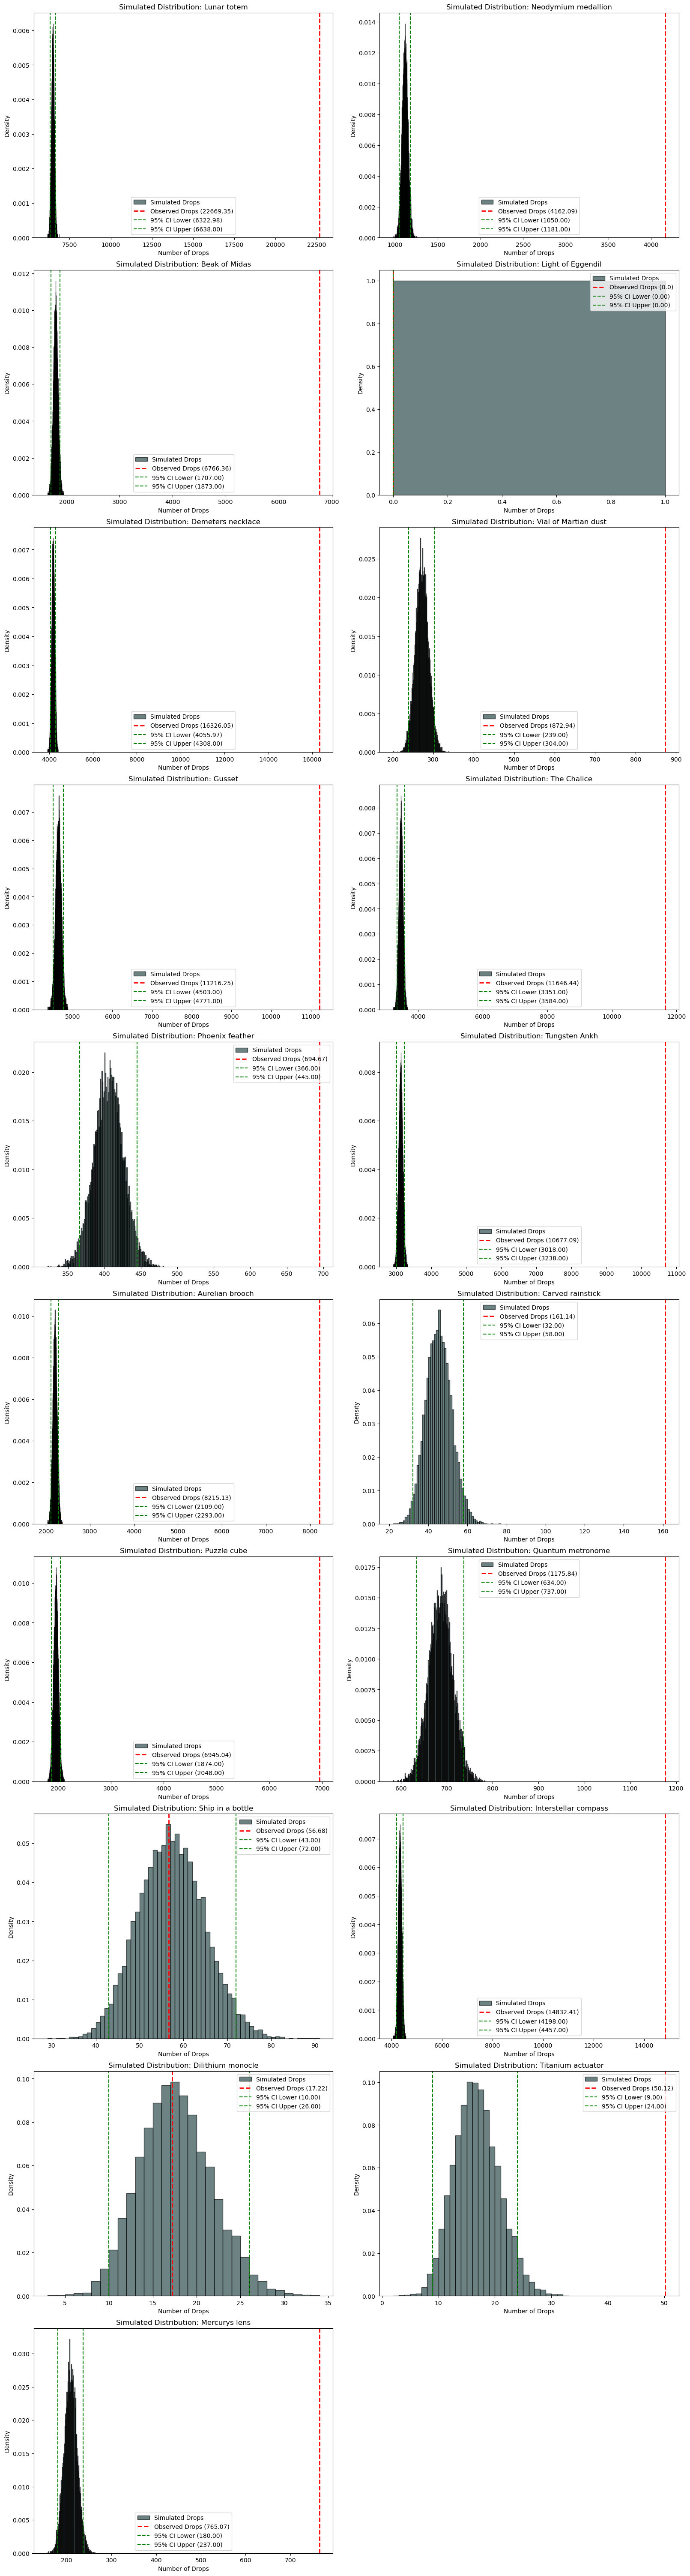

In [17]:
results = []
artifact_names = []

n_simulations = 10000

num_artifacts = artifact_data.shape[0]
rows = (num_artifacts + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(16, 6 * rows), constrained_layout=True)
axes = axes.flatten()

for i, (artifact_name, row) in enumerate(artifact_data.iterrows()):
    targeted_drop_rate = row['T Drop Rate Percent'] / 100
    untargeted_drop_rate = row['U Drop Rate Percent'] / 100
    targeted_drops = int(row['T T4 Drops'].replace(',', ''))
    untargeted_drops = int(row['U T4 Drops'].replace(',', ''))
    targeted_sample_size = int(row['T All Artifacts'].replace(',', ''))
    untargeted_sample_size = int(row['U All Artifacts'].replace(',', ''))
    
    sample_size = targeted_sample_size

    if targeted_sample_size > 0 and untargeted_sample_size > 0:
        successes = [targeted_drops, untargeted_drops]
        sample_sizes = [targeted_sample_size, untargeted_sample_size]
        try:
            stat, z_p_value = proportions_ztest(successes, sample_sizes, alternative='two-sided')
        except ZeroDivisionError:
            z_p_value = np.nan
            stat = np.nan
        z_reject_null = z_p_value < 0.05 if not np.isnan(z_p_value) else False
    else:
        z_p_value = np.nan
        stat = np.nan
        z_reject_null = False

    if targeted_sample_size > 0 and untargeted_sample_size > 0:
        np.random.seed(42)
        simulated_drops = np.random.binomial(n=sample_size, p=untargeted_drop_rate, size=n_simulations)
        observed_drops = round(targeted_drop_rate * sample_size, 2)
        sim_p_value = np.mean(simulated_drops >= observed_drops)
        ci_lower = np.percentile(simulated_drops, 2.5)
        ci_upper = np.percentile(simulated_drops, 97.5)
        sim_reject_null = sim_p_value < 0.05
    else:
        observed_drops = np.nan
        sim_p_value = np.nan
        ci_lower = np.nan
        ci_upper = np.nan
        sim_reject_null = False

    artifact_names.append(artifact_name)

    results.append({
        'Artifact': artifact_name,
        'Z-Test Reject Null': 'Yes' if z_reject_null else 'No',
        'Simulation Reject Null': 'Yes' if sim_reject_null else 'No',
        'Z-Test P-value': round(z_p_value, 2) if not np.isnan(z_p_value) else np.nan,
        'Simulation P-value': round(sim_p_value, 2) if not np.isnan(sim_p_value) else np.nan,
        'Z-Statistic': round(stat, 2) if not np.isnan(stat) else np.nan,
        'Targeted Drops': int(targeted_drops),
        'Untargeted Drops': int(untargeted_drops),
        'Targeted Sample Size': int(targeted_sample_size),
        'Untargeted Sample Size': int(untargeted_sample_size),
        'Observed Drops': observed_drops,
        '95% CI Lower': int(ci_lower),
        '95% CI Upper': int(ci_upper)
    })

    ax = axes[i]
    counts, bins, patches = ax.hist(simulated_drops, bins=range(int(min(simulated_drops)), int(max(simulated_drops)) + 2), 
                                     density=True, color='darkslategray', edgecolor='black', alpha=0.7, label="Simulated Drops")
    ax.axvline(x=observed_drops, color='red', linestyle='dashed', linewidth=2, label=f'Observed Drops ({observed_drops})')
    ax.axvline(x=ci_lower, color='green', linestyle='dashed', label=f'95% CI Lower ({ci_lower:.2f})')
    ax.axvline(x=ci_upper, color='green', linestyle='dashed', label=f'95% CI Upper ({ci_upper:.2f})')
    ax.set_title(f"Simulated Distribution: {artifact_name}")
    ax.set_xlabel("Number of Drops")
    ax.set_ylabel("Density")
    ax.legend()

    display(Markdown(f"#### <span style='background-color: lightblue; color: black; font-weight: bold;'> Artifact: {artifact_name} </span>"))
    print(f"Targeted Drop Rate: {round(observed_drops, 2)}")
    print(f"Untargeted Drop Rate (Expected): {round(untargeted_drop_rate * sample_size, 2)}")
    print(f"P-value: {sim_p_value}")
    print(f"95% Confidence Interval: [{int(ci_lower)}, {int(ci_upper)}]")
    if sim_p_value < 0.05:
        display(Markdown(f"**Reject the null hypothesis: Targeting likely affects the drop rate.**"))
    else:
        print("Fail to reject the null hypothesis: Targeting does not significantly affect the drop rate.")
    # print('\n')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.show()

In [18]:
combined_results_df = pd.DataFrame(results).set_index('Artifact')

columns_to_format = [
    'Targeted Drops', 
    'Untargeted Drops',
    'Targeted Sample Size',
    'Untargeted Sample Size',
    'Observed Drops',
    '95% CI Lower',
    '95% CI Upper'  
]

combined_results_df[columns_to_format] = combined_results_df[columns_to_format].applymap(lambda x: f"{x:,}")

combined_results_df

,Z-Test Reject Null,Simulation Reject Null,Z-Test P-value,Simulation P-value,Z-Statistic,Targeted Drops,Untargeted Drops,Targeted Sample Size,Untargeted Sample Size,Observed Drops,95% CI Lower,95% CI Upper
Artifact,,,,,,,,,,,,
Lunar totem,Yes,Yes,0.00,0.00,197.95,"22,675","610,591","1,344,564","126,629,092","22,669.35","6,322","6,638"
Neodymium medallion,Yes,Yes,0.00,0.00,91.53,"4,162","1,214,209","116,292","126,629,092","4,162.09","1,050","1,181"
Beak of Midas,Yes,Yes,0.00,0.00,117.27,"6,765","666,529","340,189","126,629,092","6,766.36","1,707","1,873"
Light of Eggendil,No,No,0.87,1.00,-0.17,0,3,"1,157,428","126,629,092",0.0,0,0
Demeters necklace,Yes,Yes,0.00,0.00,188.26,"16,327","1,801,176","294,110","126,629,092","16,326.05","4,055","4,308"
Vial of Martian dust,Yes,Yes,0.00,0.00,36.58,873,"208,389","164,396","126,629,092",872.94,239,304
Gusset,Yes,Yes,0.00,0.00,92.43,"11,201","108,283","5,392,426","126,629,092","11,216.25","4,503","4,771"
The Chalice,Yes,Yes,0.00,0.00,134.78,"11,640","201,774","2,180,982","126,629,092","11,646.44","3,351","3,584"
Phoenix feather,Yes,Yes,0.00,0.00,13.65,673,"8,580","5,788,940","126,629,092",694.67,366,445


<!-- From the analysis above, the two tests generally report the same results except those highlighted in light blue. Below is an analysis of the differences and application of these two tests: -->

### **Assumptions**

**Two Proportion Z-Test:**
- Assumes a normal approximation to the binomial distribution, which may not be accurate for small sample sizes or proportions near 0 or 1
- Uses pooled proportions to calculate the variance, which may not fully capture the distribution’s characteristics if the targeted and untargeted sample sizes or rates differ significantly

**Simulation-Based Test:**
- Relies on generating a distribution from random draws, which better accounts for the binomial nature of the data
- Does not assume normality, making it more flexible for skewed distributions or small sample sizes

In the analysis, we observe that the artifact **Ship in a Bottle** returns inconclusive results when both tests are run. However, upon closer inspection, the drop rates for the Tier 4 (T4) version of this artifact are extremely rare, sitting at **0.001 percent** for both targeted and untargeted versions. 

### **Consideration of Simulation**
In this case, the simulation-based approach is better suited for hypothesis testing. This is due to the extremely small drop rates and the fact that simulations do not rely on underlying distributional assumptions, making them more flexible in such scenarios.

### **Comparison to Light of Eggendil**
The **Ship in a Bottle** faces similar challenges as the **Light of Eggendil**:
- Both artifacts drop so infrequently that their drop rates are negligible, even when using maximum-capacity 8-star Henliners.
- This rarity makes targeting these artifacts for a direct drop almost futile, as the expected return remains extremely low regardless of targeting efforts.

These findings highlight the limitations of targeting specific artifacts with extremely rare drop rates and emphasize the importance of considering alternative acquisition methods.

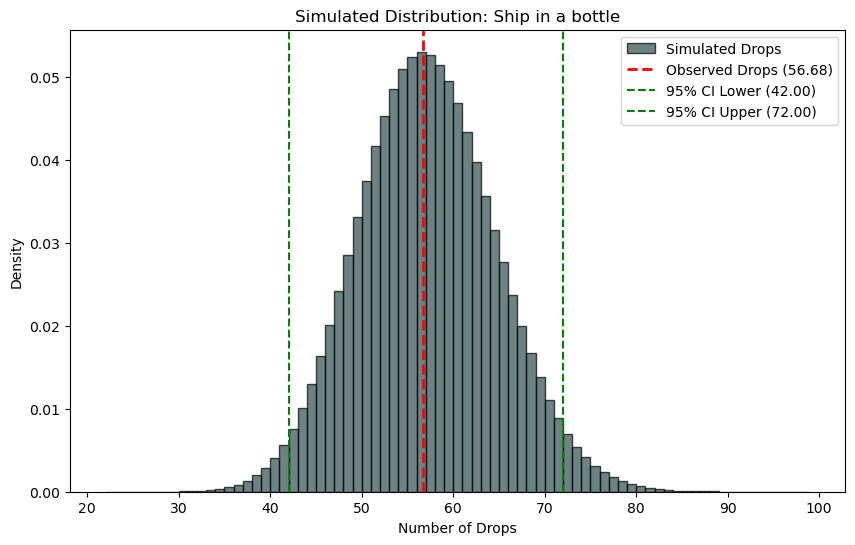

In [21]:
artifact_name_to_check = "Ship in a bottle"
n_simulations = 10000000

row = artifact_data.loc[artifact_data.index == artifact_name_to_check].iloc[0]

targeted_drop_rate = row['T Drop Rate Percent'] / 100
untargeted_drop_rate = row['U Drop Rate Percent'] / 100
targeted_drops = int(row['T T4 Drops'].replace(',', ''))
untargeted_drops = int(row['U T4 Drops'].replace(',', ''))
targeted_sample_size = int(row['T All Artifacts'].replace(',', ''))
untargeted_sample_size = int(row['U All Artifacts'].replace(',', ''))

sample_size = targeted_sample_size
siab_data = []

if targeted_sample_size > 0 and untargeted_sample_size > 0:
    successes = [targeted_drops, untargeted_drops]
    sample_sizes = [targeted_sample_size, untargeted_sample_size]
    try:
        stat, z_p_value = proportions_ztest(successes, sample_sizes, alternative='two-sided')
    except ZeroDivisionError:
        z_p_value = np.nan
        stat = np.nan
    z_reject_null = z_p_value < 0.05 if not np.isnan(z_p_value) else False
else:
    z_p_value = np.nan
    stat = np.nan
    z_reject_null = False

if targeted_sample_size > 0 and untargeted_sample_size > 0:
    np.random.seed(42)
    simulated_drops = np.random.binomial(n=sample_size, p=untargeted_drop_rate, size=n_simulations)
    observed_drops = round(targeted_drop_rate * sample_size, 2)
    sim_p_value = np.mean(simulated_drops >= observed_drops)
    ci_lower = np.percentile(simulated_drops, 2.5)
    ci_upper = np.percentile(simulated_drops, 97.5)
    sim_reject_null = sim_p_value < 0.05
else:
    observed_drops = np.nan
    sim_p_value = np.nan
    ci_lower = np.nan
    ci_upper = np.nan
    sim_reject_null = False

siab_data.append({
    'Z-Test Reject Null': 'Yes' if z_reject_null else 'No',
    'Simulation Reject Null': 'Yes' if sim_reject_null else 'No',
    'Z-Test P-value': round(z_p_value, 2) if not np.isnan(z_p_value) else np.nan,
    'Simulation P-value': round(sim_p_value, 2) if not np.isnan(sim_p_value) else np.nan,
    'Z-Statistic': round(stat, 2) if not np.isnan(stat) else np.nan,
    'Targeted Drops': int(targeted_drops),
    'Untargeted Drops': int(untargeted_drops),
    'Targeted Sample Size': int(targeted_sample_size),
    'Untargeted Sample Size': int(untargeted_sample_size),
    'Observed Drops': observed_drops,
    '95% CI Lower': ci_lower,
    '95% CI Upper': ci_upper
})

plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(simulated_drops, bins=range(int(min(simulated_drops)), int(max(simulated_drops)) + 2), 
                                 density=True, color='darkslategray', edgecolor='black', alpha=0.7, label="Simulated Drops")
plt.axvline(x=observed_drops, color='red', linestyle='dashed', linewidth=2, label=f'Observed Drops ({observed_drops})')
plt.axvline(x=ci_lower, color='green', linestyle='dashed', label=f'95% CI Lower ({ci_lower:.2f})')
plt.axvline(x=ci_upper, color='green', linestyle='dashed', label=f'95% CI Upper ({ci_upper:.2f})')
plt.title(f"Simulated Distribution: {artifact_name_to_check}")
plt.xlabel("Number of Drops")
plt.ylabel("Density")
plt.legend()
plt.show()

In [22]:
siab_df = pd.DataFrame(siab_data, index=[artifact_name_to_check])
siab_df[['Targeted Sample Size', 'Untargeted Sample Size']] = siab_df[['Targeted Sample Size', 'Untargeted Sample Size']].applymap(lambda x: f"{x:,}")
siab_df

,Z-Test Reject Null,Simulation Reject Null,Z-Test P-value,Simulation P-value,Z-Statistic,Targeted Drops,Untargeted Drops,Targeted Sample Size,Untargeted Sample Size,Observed Drops,95% CI Lower,95% CI Upper
Ship in a bottle,Yes,No,0.0,0.5,6.65,69,681,"5,667,810","126,629,092",56.68,42.0,72.0


In [23]:
artifact_data.loc[['Ship in a bottle']]

,T Legendary Drop Rate,U Legendary Drop Rate,T Drop Rate Percent,U Drop Rate Percent,T T4 Drops,T Commons,T Rares,T Epics,T Legendaries,T All Artifacts,U T4 Drops,U Commons,U Rares,U Epics,U Legendaries,U All Artifacts
Ship in a bottle,1.449,0.881,0.001,0.001,69,65,3,0,1,"5,667,810",681,651,19,5,6,"126,629,092"


The Z-Test indicates a statistically significant difference in drop rates of the Ship in a bottle artifact, but the simulation test does not support this result. This discrepancy might be due to the extremely low drop rates, which make the Z-Test sensitive to small differences while the simulation accounts for variability more effectively.

Given that both targeted and untargeted drop rates are effectively the same (0.001%), targeting the “Ship in a Bottle” artifact for T4 drops is not a viable strategy. The rarity of drops renders targeting almost ineffectual for practical gameplay purposes.

## **Targeting Results**

Based on the analysis and effectiveness of artifact targeting, here are the results:

In [26]:
targeted_effect_df = combined_results_df[combined_results_df['Simulation Reject Null'] == "Yes"].reset_index()

targeted_effect_df['Untargeted Drop Rate (%)'] = artifact_data.loc[targeted_effect_df['Artifact'], 'U Drop Rate Percent'].values
targeted_effect_df['Targeted Drop Rate (%)'] = artifact_data.loc[targeted_effect_df['Artifact'], 'T Drop Rate Percent'].values

targeted_effect_df['Targeting Effect (%)'] = (
    round(((targeted_effect_df['Targeted Drop Rate (%)'] / targeted_effect_df['Untargeted Drop Rate (%)'])) * 100, 3)
)

output_df = targeted_effect_df[['Artifact', 'Untargeted Drop Rate (%)', 'Targeted Drop Rate (%)', 'Targeting Effect (%)']]
output_df = output_df.set_index('Artifact')

output_df = output_df.sort_values(by='Targeting Effect (%)', ascending=False).round(2)

output_df

,Untargeted Drop Rate (%),Targeted Drop Rate (%),Targeting Effect (%)
Artifact,,,
Demeters necklace,1.42,5.55,390.37
Beak of Midas,0.53,1.99,378.14
Aurelian brooch,0.96,3.59,373.28
Neodymium medallion,0.96,3.58,373.20
Mercurys lens,0.03,0.11,367.74
Carved rainstick,0.08,0.27,360.53
Puzzle cube,0.40,1.41,354.27
Lunar totem,0.48,1.69,349.79
Interstellar compass,0.10,0.33,342.71


Based on the table, we observe that the **Necklace**, **Beak**, **Brooch**, and **Medallion** exhibit the highest increase in drop rates when targeting is applied. Most artifacts demonstrate over a **2x increase** in their drop rates with targeting. 

### **Exceptions**
The exceptions to this trend are the **Gusset**, **Quantum Metronome**, and **Phoenix Feather**, which show minimal improvement in drop rates when targeted.

### **Important Considerations**
While targeting often increases the drop rates of artifacts, this does not necessarily mean it is always beneficial to target them. The following points should be considered:
- **Common Versions Dominate:** Most artifact drops, even when targeted, are likely to result in common versions, which may not be particularly useful to players.
- **Rarity Chase is Difficult:** For players aiming to obtain rare or legendary versions of artifacts, the chances remain extremely low, even with targeted ships.

This highlights the importance of carefully considering the trade-offs when choosing which artifacts to target, especially for players focusing on rarities.

In [28]:
ship_capacity = {
    0: 86 * 1.5,
    1: 96 * 1.5,
    2: 106 * 1.5,
    3: 116 * 1.5,
    4: 126 * 1.5,
    5: 136 * 1.5,
    6: 146 * 1.5,
    7: 156 * 1.5,
    8: 166 * 1.5
}

true_ship_capacity = {stars: int(capacity) for stars, capacity in ship_capacity.items()}

flight_slots = 3
ship_return_time = 1.75

results = []

for artifact_name, row in output_df.iterrows():
    targeted_drop_rate = row['Targeted Drop Rate (%)'] / 100
    legendary_drop_rate = artifact_data.loc[artifact_name, 'U Legendary Drop Rate'] / 100
    p_legendary_drop = targeted_drop_rate * legendary_drop_rate
    artifact_result = {'Artifact': artifact_name}

    for stars, capacity in true_ship_capacity.items():
        expected_legendaries_per_ship = capacity * p_legendary_drop
        if expected_legendaries_per_ship > 0:
            ships_needed = 1 / expected_legendaries_per_ship
        else:
            ships_needed = float('inf')
        average_days = (ships_needed / flight_slots) * ship_return_time
        artifact_result[f'Star {stars} (Cap {capacity})'] = int(average_days)

    results.append(artifact_result)

average_days_df = pd.DataFrame(results)
average_days_df.set_index('Artifact', inplace=True)

average_days_df = average_days_df.sort_values(by='Star 0 (Cap 129)', ascending=True).applymap(lambda x: f"{x:,}")
average_days_df

,Star 0 (Cap 129),Star 1 (Cap 144),Star 2 (Cap 159),Star 3 (Cap 174),Star 4 (Cap 189),Star 5 (Cap 204),Star 6 (Cap 219),Star 7 (Cap 234),Star 8 (Cap 249)
Artifact,,,,,,,,,
Demeters necklace,22,19,17,16,15,13,13,12,11
Aurelian brooch,33,29,26,24,22,20,19,18,17
Neodymium medallion,34,30,27,25,23,21,20,19,17
Beak of Midas,80,72,65,59,55,51,47,44,41
Puzzle cube,86,77,70,64,59,54,51,47,45
Lunar totem,98,88,80,73,67,62,58,54,51
Tungsten Ankh,110,99,89,82,75,70,65,61,57
Vial of Martian dust,223,200,181,166,152,141,131,123,116
The Chalice,224,201,182,166,153,141,132,123,116


The table above displays the **average number of days required** to obtain the legendary variant of each artifact using targeting, assuming:
- **Maximum Epic Research** is applied.
- **3 Flight Slots** are used for ship launches.

### **Takeaways**
Despite the increased efficiency from targeting and research, the time required to obtain legendary artifacts remains extremely high. This makes **direct targeting with ships** an impractical method for acquiring legendary artifacts such as the Phoenix feather or Quantum metronome.

## Other Artifact Tiers

Let's take a look at other artifact tiers and how targeting impacts their drop rates.

In [31]:
artifact_dfs = {}

for artifact_id in range(0, 53):
    artifact_name = Artifact_dict[artifact_id]
    if(artifact_name == 'n/a'):
        continue
    
    # display(Markdown(f"#### Drop rates for {artifact_name}"))
    
    data = {
        "Artifact": [],
        "Untargeted Proportion": [],
        "Targeted Proportion": [],
        "Targeted Percentage Increase": [],
        "Untargeted Drops": [],
        "Targeted Drops": []
    }

    end = 4
    if('stone' in artifact_name):
            end = 3
    for tier in range(0, end):

        u_all_artis = ships[(ships['Target artifact ID'] == 10000)]['Total drops'].sum()
        u_tier_sum = ships[(ships['Artifact type ID'] == artifact_id) & 
                           (ships['Artifact tier'] == tier) &
                           (ships['Target artifact ID'] == 10000)]['Total drops'].sum()
        
        t_all_artis = ships[ships['Target artifact ID'] == artifact_id]['Total drops'].sum()
        t_tier_sum = ships[(ships['Artifact type ID'] == artifact_id) &
                           (ships['Target artifact ID'] == artifact_id) &
                           (ships['Artifact tier'] == tier)]['Total drops'].sum()

        if u_tier_sum == 0:
            u_tier_sum = 'Doesn\'t Drop'
            increase = 'N/A'
            untargeted_prop = 'N/A'
            targeted_prop = round(t_tier_sum * 100 / t_all_artis, 2)
            t_tier_sum = "{:,}".format(t_tier_sum)
        elif t_tier_sum == 0:
            t_tier_sum = 'Doesn\'t Drop'
            increase = 'N/A'
            targeted_prop = 'N/A'
            untargeted_prop = round(u_tier_sum * 100 / u_all_artis, 2)
            u_tier_sum = "{:,}".format(u_tier_sum)
        else:
            untargeted_prop = round(u_tier_sum * 100 / u_all_artis, 2)
            targeted_prop = round(t_tier_sum * 100 / t_all_artis, 2)
            increase = round((t_tier_sum / t_all_artis) / (u_tier_sum  / u_all_artis), 2)
            u_tier_sum = "{:,}".format(u_tier_sum)
            t_tier_sum = "{:,}".format(t_tier_sum)
        
        data["Artifact"].append(f"T{tier + 1} {artifact_name}")
        data["Untargeted Proportion"].append(untargeted_prop)
        data["Targeted Proportion"].append(targeted_prop)
        data["Targeted Percentage Increase"].append(increase)
        data["Untargeted Drops"].append(u_tier_sum)
        data["Targeted Drops"].append(t_tier_sum)
    
    artifact_df = pd.DataFrame(data).set_index('Artifact')
    artifact_dfs[artifact_name] = artifact_df

    # if('fragment' in artifact_name):
    #     display(artifact_df.head(1))
    # else:
    #     display(artifact_df)
    # print('\n')

output_dir = "artifact_data"
os.makedirs(output_dir, exist_ok=True)
all_artifacts_data = []

for artifact_name, artifact_df in artifact_dfs.items():
    safe_name = artifact_name.replace(' ', '_').replace('/', '_')
    filename = f"{output_dir}/{safe_name}.csv"

    if 'fragment' in artifact_name.lower():
        artifact_df.head(1).to_csv(filename)
    else:
        artifact_df.to_csv(filename)

    # combined_df = artifact_df.assign(Artifact=artifact_name)
    all_artifacts_data.append(artifact_df)

big_df = pd.concat(all_artifacts_data)

big_file_name = "all_artifact_drop_rates.csv"
big_df.to_csv(big_file_name, index=True)

Taking a look at the csv file, we can see that across the board, we generally get more artifacts we target across tiers. 

## **Does targeting affect legendary drop rates?**

Although targeting increases how many artifacts we target, does this affect the overall drop rates of all legendaries from ships? Does targeting one artifact lower the expected drops of all other legendaries? 

In [35]:
legendary_drops = []
untargeted_more_legendaries = []
targeted_more_legendaries = []

sig_diff = []

for artifact_id in range(0, 53):
    artifact_name = Artifact_dict[artifact_id]
    if(artifact_name == 'n/a'):
        continue

    u_all_artis = ships[(ships['Target artifact ID'] == 10000)]['Total drops'].sum()
    t_all_artis = ships[ships['Target artifact ID'] == artifact_id]['Total drops'].sum()

    u_legendaries = ships[(ships['Target artifact ID'] == 10000) &
        (ships['Artifact rarity ID'] == 3)]['Total drops'].sum()
    t_legendaries = ships[(ships['Target artifact ID'] == artifact_id) &
        (ships['Artifact rarity ID'] == 3)]['Total drops'].sum()

    u_prop = round(u_legendaries*100/u_all_artis, 3)
    t_prop = round(t_legendaries*100/t_all_artis, 3)

    sorter = t_prop - u_prop

    if u_prop > t_prop:
        u_prop = f"<span style='background-color: lightblue; color: black; font-weight: bold;'>{u_prop}</span>"
        untargeted_more_legendaries.append(artifact_name)
    else:
        if t_prop - 0.005 > u_prop:
            sig_diff.append(artifact_name)
        t_prop = f"<span style='background-color: lightblue; color: black; font-weight: bold;'>{t_prop}</span>"
        targeted_more_legendaries.append(artifact_name)
                          
    u_all_artis = "{:,}".format(u_all_artis)
    t_all_artis = "{:,}".format(t_all_artis)
    u_legendaries = "{:,}".format(u_legendaries)
    t_legendaries = "{:,}".format(t_legendaries)

    legendary_drops.append({
        'Artifact': artifact_name,
        'Untargeted legendaries rate (%)': u_prop,
        'Targeted legendaries rate (%)': t_prop,
        'Untargeted total legendaries': u_legendaries,
        'Untargeted total artifacts': u_all_artis,
        'Targeted total legendaries': t_legendaries,
        'Targeted total artifacts': t_all_artis,
        'Sort': sorter
    })

legendaries_droprate_df = pd.DataFrame(legendary_drops).set_index('Artifact').sort_values('Sort', ascending=False)
legendaries_droprate_df.drop('Sort', axis=1, inplace=True)
# display(Markdown(legendaries_droprate_df.to_markdown())) # To view with markdown formatting
legendaries_droprate_df.to_csv('legendaries_droprate.csv', index=True)

From the table below, we observe that only the **first 5 or so artifacts** achieve a meaningful increase in legendary drop rates through targeting. This suggests that:

- **Targeting these specific artifacts** may be beneficial for players who are interested in acquiring them.
- **Targeting other artifacts** on the list is likely to result in a **decrease in the expected drops of legendary artifacts overall**.

### **Fragment Targets**
Fragment targets have been excluded from this list due to the limited number of samples available. Additionally, it is much more efficient to target the stones directly rather than relying on fragment drops.

This analysis highlights the importance of prioritizing specific artifacts when targeting, while being cautious of the trade-offs involved for legendary drop rates in general.

In [37]:
filtered_df = legendaries_droprate_df[~legendaries_droprate_df.index.str.contains('fragment', case=False)]

display(Markdown(filtered_df.head(10).to_markdown()))

| Artifact             | Untargeted legendaries rate (%)                                                          | Targeted legendaries rate (%)                                                            | Untargeted total legendaries   | Untargeted total artifacts   |   Targeted total legendaries | Targeted total artifacts   |
|:---------------------|:-----------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------|:-------------------------------|:-----------------------------|-----------------------------:|:---------------------------|
| Tungsten Ankh        | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.047</span> | 34,070                         | 126,629,092                  |                          468 | 993,218                    |
| Demeters necklace    | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.037</span> | 34,070                         | 126,629,092                  |                          110 | 294,110                    |
| Aurelian brooch      | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.035</span> | 34,070                         | 126,629,092                  |                           80 | 228,770                    |
| Beak of Midas        | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.029</span> | 34,070                         | 126,629,092                  |                           98 | 340,189                    |
| Vial of Martian dust | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.029</span> | 34,070                         | 126,629,092                  |                           48 | 164,396                    |
| Neodymium medallion  | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> | 34,070                         | 126,629,092                  |                           31 | 116,292                    |
| Puzzle cube          | 0.027                                                                                    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> | 34,070                         | 126,629,092                  |                          132 | 492,556                    |
| Shell stone          | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> | 0.026                                                                                    | 34,070                         | 126,629,092                  |                            6 | 23,194                     |
| Lunar totem          | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> | 0.026                                                                                    | 34,070                         | 126,629,092                  |                          346 | 1,344,564                  |
| Quantum stone        | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> | 0.025                                                                                    | 34,070                         | 126,629,092                  |                           30 | 120,050                    |

Below are the artifacts that suffer the most from targeting in terms of legendary drops. The artifact with the **lowest performance** on this list is the **Light of Eggendil**, which only drops from max-level Henliners.

### **Key Observations**
- Even for artifacts that suffer the most from targeting, the decrease in legendary drop rates is only a **fraction of a percent**.
- This minimal decrease suggests that **targeting for materials** may not significantly impact the overall number of legendary drops a player can expect.

### **Implications**
Players targeting materials for crafting can do so with minimal concern about negatively affecting their legendary drop rates, even for artifacts like the Light of Eggendil.

In [39]:
# display(Markdown(legendaries_droprate_df.tail(10).to_markdown()))

display(Markdown(filtered_df.tail(10).to_markdown()))

| Artifact          | Untargeted legendaries rate (%)                                                          |   Targeted legendaries rate (%) | Untargeted total legendaries   | Untargeted total artifacts   | Targeted total legendaries   | Targeted total artifacts   |
|:------------------|:-----------------------------------------------------------------------------------------|--------------------------------:|:-------------------------------|:-----------------------------|:-----------------------------|:---------------------------|
| Tachyon stone     | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.022 | 34,070                         | 126,629,092                  | 58                           | 264,930                    |
| Light of Eggendil | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.021 | 34,070                         | 126,629,092                  | 248                          | 1,157,428                  |
| Gusset            | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.021 | 34,070                         | 126,629,092                  | 1,151                        | 5,392,426                  |
| Soul stone        | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.02  | 34,070                         | 126,629,092                  | 205                          | 1,025,158                  |
| Tau ceti geode    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.02  | 34,070                         | 126,629,092                  | 6,246                        | 31,733,929                 |
| Carved rainstick  | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.019 | 34,070                         | 126,629,092                  | 11                           | 58,809                     |
| Solar titanium    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.019 | 34,070                         | 126,629,092                  | 422                          | 2,228,561                  |
| Titanium actuator | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.019 | 34,070                         | 126,629,092                  | 19                           | 102,292                    |
| Gold meteorite    | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.017 | 34,070                         | 126,629,092                  | 2,990                        | 17,305,057                 |
| Terra stone       | <span style='background-color: lightblue; color: black; font-weight: bold;'>0.027</span> |                           0.017 | 34,070                         | 126,629,092                  | 5                            | 28,596                     |

## **Number of Crafts For Shinies**

Since it may not be efficient to target artifacts for drops, let's explore **crafting** as an alternative method to obtain legendary artifacts. We are particularly interested in crafting **legendary variants**. The formula for crafting probabilities can be found [here](https://egg-inc.fandom.com/wiki/Crafting) and will serve as a guide for calculating probabilities.

For artifact rarities rare and above (epic and legendaries), we will refer to them as shinies due to their glow in the Hall of Artifacts in-game.

### **Formula for Shinies**
The crafting probability formula for shiny artifacts is as follows:

$$
\text{shiny chance(previous crafts)} = \min \left( 
    \text{constant}, 
    \min \left( 
        \frac{1}{10}, 
        \max \left( 
            10, 
            \frac{\text{constant}}{\text{level multiplier}} 
        \right)^{0.3 \cdot \min \left( 1, \frac{\text{previous crafts}}{400} \right) - 1} 
    \right) 
\right)
$$

This formula determines the probability of crafting a shiny artifact, taking into account:
- A **constant** specific to the artifact.
- A **level multiplier** based on the artifact's crafting level.
- The number of **previous crafts** performed.

### **Simulation Example**
We can simulate how many crafts are required to obtain a **Tier 4 Legendary Gusset** (T4L Gusset) with:
- **Constant:** 1000
- **Level Multiplier:** 2.5 (for level 20)
- Starting from **0 crafts**.

### **Adjustments for Higher Levels**
For artifacts crafted at levels higher than 20, it is unlikely that this is the player's first time crafting. Therefore, an adjustment is made to the number of previous crafts:
- A conservative estimate of **10 crafts per 0.5 increase in level multiplier** is assumed.
- This adjustment accounts for the increased crafting experience required at higher levels.

This assumption is suitable for most artifacts, except for **rare artifacts** such as the **Book of Basan** and **Tachyon Deflector**. These rare artifacts rely heavily on chance, making direct analysis less helpful. However, their constants are similar to those of artifacts in this analysis, allowing for reasonable inferences.

### **Visualization**
On the graphs below:
- The **lower quartile**, **upper quartile**, **median**, and **90th percentile** for the number of crafts required are marked.
- These metrics help illustrate the variability in crafting attempts needed to obtain legendary artifacts.

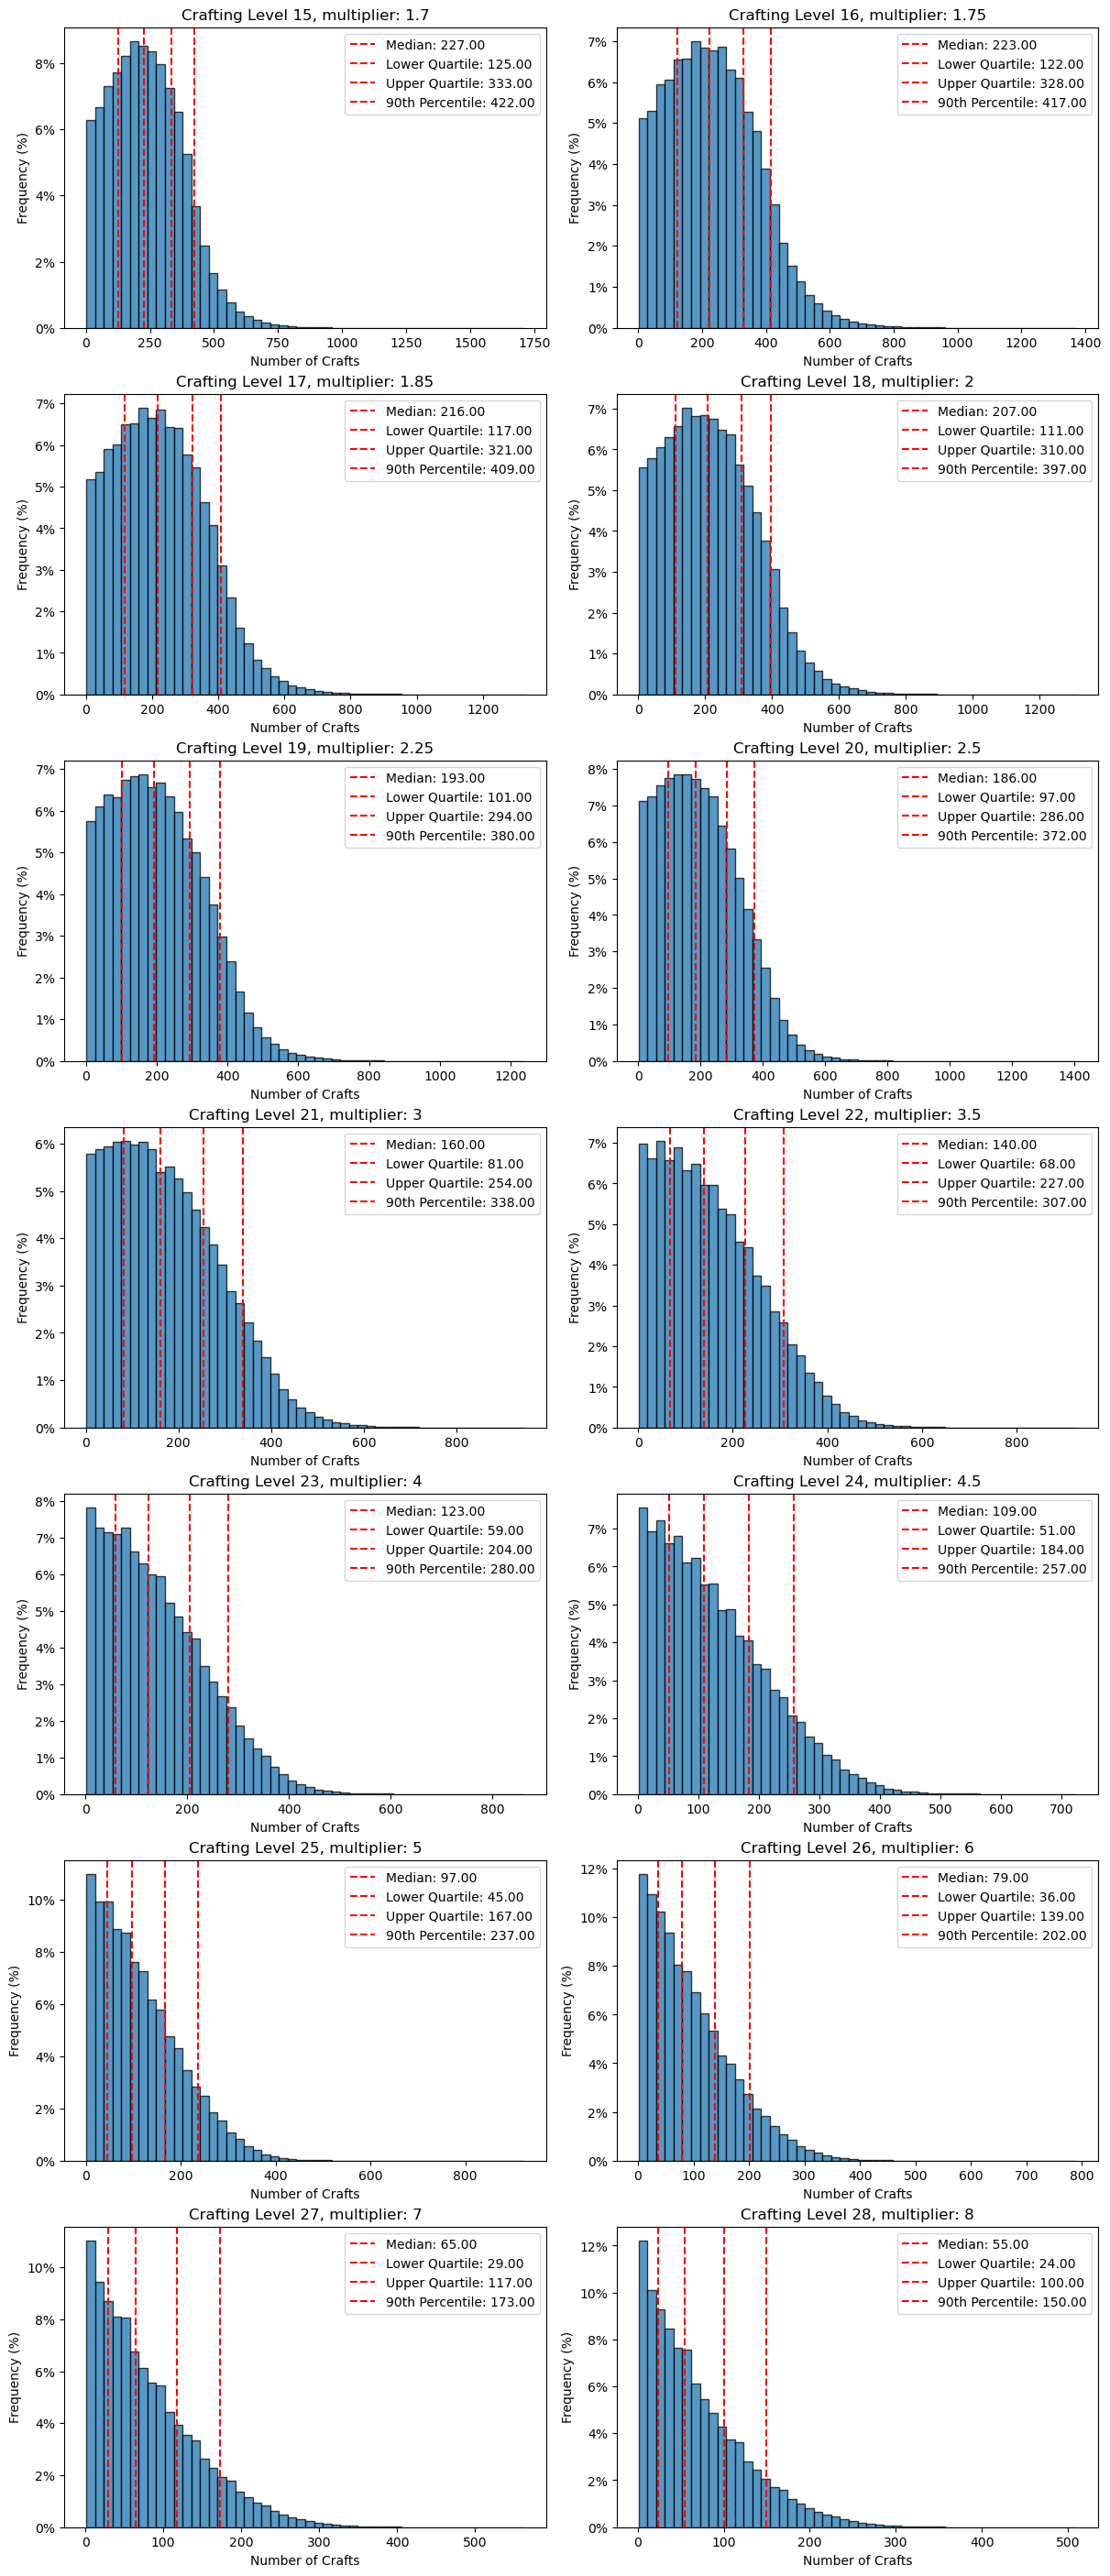

In [42]:
crafting_levels = {
    15: 1.7,
    16: 1.75,
    17: 1.85,
    18: 2,
    19: 2.25,
    20: 2.5,
    21: 3,
    22: 3.5,
    23: 4,
    24: 4.5,
    25: 5,
    26: 6,
    27: 7,
    28: 8,
}

simulations=1000000
constant=1000

@njit
def shiny_chance(pc,m):
    if m < 2.5:
        return min(constant,min(0.1,max(10,constant/m)**(0.3*min(1,pc/400)-1)))
    else:
        pc += (m - 3) * 20
        return min(constant,min(0.1,max(10,constant/m)**(0.3*min(1,pc/400)-1)))

@njit(parallel=True)
def run_sims(n,m):
    r=np.empty(n,dtype=np.int32)
    for i in prange(n):
        c=0
        while True:
            if random.random()<shiny_chance(c,m):
                r[i]=c+1
                break
            c+=1
    return r

nl=len(crafting_levels)
rows=(nl+1)//2
fig,axes=plt.subplots(rows,2,figsize=(12,4*rows),constrained_layout=True)
axes=axes.flatten()

for i,(lvl,mult) in enumerate(crafting_levels.items()):
    nc=run_sims(simulations,mult)
    mean=np.mean(nc)
    median=np.median(nc)
    lq = np.percentile(nc, 25)
    uq = np.percentile(nc, 75)
    ninety = np.percentile(nc, 90)
    std=np.std(nc)
    mo=1.96*(std/np.sqrt(simulations))
    lb=mean-mo
    ub=mean+mo
    ax=axes[i]
    ax.hist(nc,bins=50,alpha=0.75,edgecolor='black',weights=np.ones_like(nc)/len(nc))
    ax.set_title(f'Crafting Level {lvl}, multiplier: {mult}')
    ax.set_xlabel('Number of Crafts')
    ax.set_ylabel('Frequency (%)')
    # ax.axvline(mean,color='red',linestyle='dashed',linewidth=1.5,label=f'Mean: {mean:.2f}')
    ax.axvline(median,color='red',linestyle='dashed',linewidth=1.5,label=f'Median: {median:.2f}')
    ax.axvline(lq,color='red',linestyle='dashed',linewidth=1.5,label=f'Lower Quartile: {lq:.2f}')
    ax.axvline(uq,color='red',linestyle='dashed',linewidth=1.5,label=f'Upper Quartile: {uq:.2f}')
    ax.axvline(ninety,color='red',linestyle='dashed',linewidth=1.5,label=f'90th Percentile: {ninety:.2f}')
    # ax.axvline(lb,color='blue',linestyle='dashed',linewidth=1.5,label=f'95% Mean CI Lower: {lb:.2f}')
    # ax.axvline(ub,color='blue',linestyle='dashed',linewidth=1.5,label=f'95% Mean CI Upper: {ub:.2f}')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y,_:f'{y*100:.0f}%'))
    ax.legend()

for j in range(len(crafting_levels),len(axes)):
    fig.delaxes(axes[j])

plt.show()

Many of these crafting distributions are **left-skewed**, meaning that as players craft more artifacts, the likelihood of not obtaining any rarity becomes increasingly uncommon.

### **Key Observations**
- For **lower crafting levels**, the median number of crafts required to obtain a legendary is around **200 crafts**.
- For **higher crafting levels**, this same number shifts to the **90th percentile**, indicating a **50% probability** of obtaining a legendary after crafting at least **200 artifacts**.

### **Implications for Specific Artifacts**
For artifacts such as the **Gusset**, **Phoenix Feather**, and **Quantum Metronome**, crafting provides a **much higher chance** of obtaining legendaries in a **timely manner** compared to relying on ship drops. This makes crafting an effective and efficient method for pursuing legendary variants of these artifacts.

## **Conclusion**

The results from this analysis indicate that **targeting** most likely has a **positive effect** on drop rates for many artifacts. However, the increase is **moderate in most cases**, and given the rarity of direct drops from ships, legendary artifacts remain uncommon even with targeting.

### **Recommendations for New Players**
- **Untargeted Ships:**  
  For new players, sending untargeted ships may be the best strategy to obtain legendary artifacts generally. In many cases, targeting lowers the yield of all legendary drops from ships.
  - **Advantages of Untargeted Ships:**  
    Having multiple copies of a legendary can be useful for assembling different in-game artifact sets. Untargeted ships increase the overall variety and quantity of legendaries obtained.
- **Crafting Costs:**  
  Crafting remains **expensive** for new players, as costs only decrease with the number of previous crafts. Additionally, the probabilities of obtaining legendaries through crafting are still relatively low at lower crafting levels.

### **Recommendations for Veteran Players**
- **Targeting for Specific Artifacts:**  
  For veteran players, targeting becomes almost essential. These players likely already have **multiple copies of common legendaries**, so their focus shifts to obtaining rare artifacts that are easier to acquire through crafting.
- **Crafting Advantages:**  
  Veteran players benefit from:
  - **Higher crafting levels** and **more previous crafts**, which increase the probability of crafting a shiny artifact.
  - **Lower crafting costs**, which reduce the resource burden of crafting rare and legendary artifacts.

### **Conclusion**
For new players, untargeted ships provide better overall legendary yield and variety. In contrast, veteran players benefit more from targeting specific artifacts and leveraging crafting due to their increased crafting efficiency and reduced costs. The optimal strategy depends on the player's progress and goals within the game.

These artifacts would most likely be feasible to target:

In [59]:
display(Markdown(f"#### **Expected Average Days of Legendary Drop with Targeting**"))
average_days_df.head(7)

#### **Expected Average Days of Legendary Drop with Targeting**

,Star 0 (Cap 129),Star 1 (Cap 144),Star 2 (Cap 159),Star 3 (Cap 174),Star 4 (Cap 189),Star 5 (Cap 204),Star 6 (Cap 219),Star 7 (Cap 234),Star 8 (Cap 249)
Artifact,,,,,,,,,
Demeters necklace,22,19,17,16,15,13,13,12,11
Aurelian brooch,33,29,26,24,22,20,19,18,17
Neodymium medallion,34,30,27,25,23,21,20,19,17
Beak of Midas,80,72,65,59,55,51,47,44,41
Puzzle cube,86,77,70,64,59,54,51,47,45
Lunar totem,98,88,80,73,67,62,58,54,51
Tungsten Ankh,110,99,89,82,75,70,65,61,57


These artifacts can be targeted if you are willing to wait a few months:

In [49]:
display(Markdown(f"#### **Expected Average Days of Legendary Drop with Targeting**"))
average_days_df.iloc[7:12]

,Star 0 (Cap 129),Star 1 (Cap 144),Star 2 (Cap 159),Star 3 (Cap 174),Star 4 (Cap 189),Star 5 (Cap 204),Star 6 (Cap 219),Star 7 (Cap 234),Star 8 (Cap 249)
Artifact,,,,,,,,,
Vial of Martian dust,223,200,181,166,152,141,131,123,116
The Chalice,224,201,182,166,153,141,132,123,116
Interstellar compass,355,318,288,263,242,225,209,196,184
Carved rainstick,407,365,330,302,278,257,240,224,211
Gusset,526,471,427,390,359,332,310,290,272


These artifacts should be crafted:

In [61]:
display(Markdown(f"#### **Expected Average Days of Legendary Drop with Targeting**"))
average_days_df.iloc[12:]

#### **Expected Average Days of Legendary Drop with Targeting**

,Star 0 (Cap 129),Star 1 (Cap 144),Star 2 (Cap 159),Star 3 (Cap 174),Star 4 (Cap 189),Star 5 (Cap 204),Star 6 (Cap 219),Star 7 (Cap 234),Star 8 (Cap 249)
Artifact,,,,,,,,,
Mercurys lens,"1,216","1,089",986,901,830,769,716,670,630
Titanium actuator,"2,266","2,030","1,838","1,680","1,547","1,433","1,335","1,249","1,174"
Phoenix feather,"12,526","11,221","10,162","9,286","8,549","7,920","7,378","6,905","6,489"
Quantum metronome,"16,324","14,624","13,244","12,102","11,142","10,323","9,615","8,999","8,457"
